# Regime Detection in Financial Markets Using Hidden Markov Models

### Abstract

Financial markets frequently transition between distinct behavioral regimes that are difficult to detect in real time. Accurately identifying market regimes can enhance risk management, improve allocation timing, and provide more stable trading signals. This project investigates whether a two-, three-, or four-state Hidden Markov Model (HMM) applied to 26 years of historical SPY price data can uncover these latent structures and offer actionable insights. 

Unobserved market regimes can be inferred by using a Gaussian HMM to model daily returns and volatility-based features. The analysis uses 26 years of historical SPY data and evaluates how well the model distinguishes between trend-following and risk-off environments. Regime characteristics are quantified, and a simple backtest is performed to assess practical usefulness. 

A four-state HMM appears to be the best-fit model for the SPY data, but may be overfit. Regimes are classified as Bull, Bear, Sideways (high volatility leaning toward Bull), and HighVol (high volatility leaning toward Bear). A three-state HMM is the next best option if the four-state HMM is overfit, where regimes are classified as Bull, Bear, and Sideways (high volatility). Return vs. Volatility is visualized with sections highlighted to showcase major financial events, and a backtest is performed to assess the real-world usefulness of the model. The sideways regime appears to indicate a warning that a potential bear regime may be approaching. Once the regime switches to bull, it's safe to invest until the next sideways regime. The backtest shows whether the model is under- or overperforming the historical SPY data and is following the historical data closely, while usually overperforming.

### Data & Features

<u>SPDR S&P 500 ETF Trust (SPY):</u> Standard and Poor's (S&P) 500 is a stock market index that tracks the stock performance of the top 500 U.S. companies listed on stock exchanges. SPY is one of the exchange-trading funds that tracks S&P 500.

This analysis uses daily market data from the SPDR S&P 500 ETF Trust (SPY); an exchange-traded fund that tracks the S&P 500 index. The S&P 500 represents the performance of the top 500 U.S. companies that lead the financial stability of the economy, and SPY offers highly liquid, long-term historical data suitable for regime analysis.

<u>Cboe Volatility Index (VIX):</u> A real-time market index that adds volatility dimension that improves regime detection. It measures expected volatility for the next 30 days and is often considered the "fear gauge" because it tends to spike during times of market uncertainty.

To enhance regime detection, the Cboe Volatility Index (VIX) is added to the SPY dataset. VIX is a forward-looking measure of expected 30-day market volatility, and often spikes during uncertainty and provides an additional dimension for distinguishing bear or high-volatility regimes. 

In [184]:
import stockdex as sd
from stockdex import Ticker
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from typing import Optional, Union

In [185]:
# Collect SPY data for the past 26 years
spy_ticker = Ticker(ticker='SPY')
spydata = spy_ticker.yahoo_api_price(range='26y', dataGranularity='1d')
spydata.set_index(pd.DatetimeIndex(spydata['timestamp']), inplace=True)
spydata.head()

,timestamp,volume,close,open,high,low,currency,timezone,exchangeTimezoneName,exchangeName,instrumentType
timestamp,,,,,,,,,,,
1999-11-08 14:30:00,1999-11-08 14:30:00,4649200,138.000000,137.0000,138.375000,136.750000,USD,EST,America/New_York,PCX,ETF
1999-11-09 14:30:00,1999-11-09 14:30:00,4533700,136.703125,138.5000,138.687500,136.281250,USD,EST,America/New_York,PCX,ETF
1999-11-10 14:30:00,1999-11-10 14:30:00,6405600,137.718750,136.2500,138.390625,136.078125,USD,EST,America/New_York,PCX,ETF
1999-11-11 14:30:00,1999-11-11 14:30:00,4794100,138.500000,138.1875,138.500000,137.468750,USD,EST,America/New_York,PCX,ETF
1999-11-12 14:30:00,1999-11-12 14:30:00,11802900,139.750000,139.2500,139.984375,137.125000,USD,EST,America/New_York,PCX,ETF


In [186]:
# Collect VIX data for the past 26 years
vix_ticker = Ticker(ticker='^VIX')
vix = vix_ticker.yahoo_api_price(range='26y', dataGranularity='1d')
vix['timestamp'] = vix['timestamp'].dt.date
vix.set_index(pd.DatetimeIndex(vix['timestamp']), inplace=True)
#vix.set_index('timestamp', inplace=True)
vix = vix[['close']].rename(columns={'close': 'VIX'})
vix.head()

,VIX
timestamp,
1999-11-08,21.870001
1999-11-09,22.700001
1999-11-10,22.260000
1999-11-11,22.070000
1999-11-12,21.650000


In [187]:
# Combine datasets
data = pd.merge_asof(spydata, vix, left_index=True, right_index=True)
data.head()

,timestamp,volume,close,open,high,low,currency,timezone,exchangeTimezoneName,exchangeName,instrumentType,VIX
timestamp,,,,,,,,,,,,
1999-11-08 14:30:00,1999-11-08 14:30:00,4649200,138.000000,137.0000,138.375000,136.750000,USD,EST,America/New_York,PCX,ETF,21.870001
1999-11-09 14:30:00,1999-11-09 14:30:00,4533700,136.703125,138.5000,138.687500,136.281250,USD,EST,America/New_York,PCX,ETF,22.700001
1999-11-10 14:30:00,1999-11-10 14:30:00,6405600,137.718750,136.2500,138.390625,136.078125,USD,EST,America/New_York,PCX,ETF,22.260000
1999-11-11 14:30:00,1999-11-11 14:30:00,4794100,138.500000,138.1875,138.500000,137.468750,USD,EST,America/New_York,PCX,ETF,22.070000
1999-11-12 14:30:00,1999-11-12 14:30:00,11802900,139.750000,139.2500,139.984375,137.125000,USD,EST,America/New_York,PCX,ETF,21.650000


#### Engineered Features

To help the Hidden Markov Model capture underlying market structure, several time-series features are added:
- <b>Return:</b> Daily percentage return based on SPY closing price.
- <b>Volatility:</b> 20-day rolling standard deviation of returns, capturing market uncertainty.
- <b>LagReturn:</b> Previous day's return, used to add temporal dependency beneficial for modeling regime transitions.
- <b>VolumeChange:</b> Daily percentage change in trading volume, highlighting shifts in market activity.

In [188]:
# Feature engineering
# Calculate daily returns (market movement)
data['Return'] = data['close'].pct_change()

# Rolling volatility (20-day rolling std of returns) (market uncertainty)
data['Volatility'] = data['Return'].rolling(window=20).std()

# Lagged return (yesterday's return) (adds temporal dependency, helping HMM learn transitions
data['LagReturn'] = data['Return'].shift(1)

# Daily percentage change in trading volume
data['VolumeChange'] = data['volume'].pct_change()

# Drop missing values (~20 rows)
data.dropna(inplace=True)
data.head()

,timestamp,volume,close,open,high,low,currency,timezone,exchangeTimezoneName,exchangeName,instrumentType,VIX,Return,Volatility,LagReturn,VolumeChange
timestamp,,,,,,,,,,,,,,,,
1999-12-07 14:30:00,1999-12-07 14:30:00,10714200,141.62500,143.28125,143.31250,141.37500,USD,EST,America/New_York,PCX,ETF,21.090000,-0.008098,0.007893,-0.007386,2.413361
1999-12-08 14:30:00,1999-12-08 14:30:00,4611400,140.71875,141.34375,142.06250,140.50000,USD,EST,America/New_York,PCX,ETF,21.250000,-0.006399,0.007705,-0.008098,-0.569599
1999-12-09 14:30:00,1999-12-09 14:30:00,6474700,141.40625,141.81250,142.21875,139.37500,USD,EST,America/New_York,PCX,ETF,21.190001,0.004886,0.007622,-0.006399,0.404064
1999-12-10 14:30:00,1999-12-10 14:30:00,5127300,141.87500,142.28125,142.81250,140.87500,USD,EST,America/New_York,PCX,ETF,21.480000,0.003315,0.007569,0.004886,-0.208102
1999-12-13 14:30:00,1999-12-13 14:30:00,4210800,142.12500,141.43750,142.71875,141.28125,USD,EST,America/New_York,PCX,ETF,21.719999,0.001762,0.007347,0.003315,-0.178749


### Methodology

<b>Normalize Features for HMM</b><br>
Normalizing the Return, Volatility, LagReturn, and VIX features improves the training stability and performance of the HMM, and prevents features with larger ranges from dominating the model.

<b>Fit the Model</b><br>
A Gaussian HMM model is fit using two, three, and four components and the normalized Return, Volatility, LagReturn, and VIX features. The three Gaussian HMMs are evaluated for the best fit using the lowest Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) values, and the log-likelihood value closest to 0.

In [189]:
# Normalize features for HMM
scaler = StandardScaler()
features = scaler.fit_transform(data[['Return', 'Volatility', 'LagReturn', 'VIX']])
X = scaler.fit_transform(features)

In [217]:
# Evaluate Fit (Log-likelihood, AIC, BIC)
def fit_hmm(X, n):
    model = GaussianHMM(n_components=n, covariance_type='full', n_iter=1000, random_state=42)
    model.fit(X)
    return model

for n in [2, 3, 4]:
    model = fit_hmm(X, n)
    print(f'{n} regimes: log-likelihood = {model.score(X):.2f}, AIC = {-2*model.score(X) + 2*n}, BIC = {-2*model.score(X) + n*np.log(len(X))}')

2 regimes: log-likelihood = -23420.23, AIC = 46844.45827474501, BIC = 46858.023840779795
3 regimes: log-likelihood = -22980.18, AIC = 45966.35545343207, BIC = 45986.703802484255
4 regimes: log-likelihood = -19887.73, AIC = 39783.45602990574, BIC = 39810.587161975316


Using a Gaussian HMM with four components appears to be the best-fit model. 

### Results

In [ ]:
# Plotting, backtest
# Explain SPY Daily Returns and Rolling Volatility

Plotting SPY daily returns and rolling volatility together shows the relationship between the daily returns and volatility and can provide insight into how volatility affects daily returns. Major financial events are highlighted to show how daily returns and volatility are affected during these events.

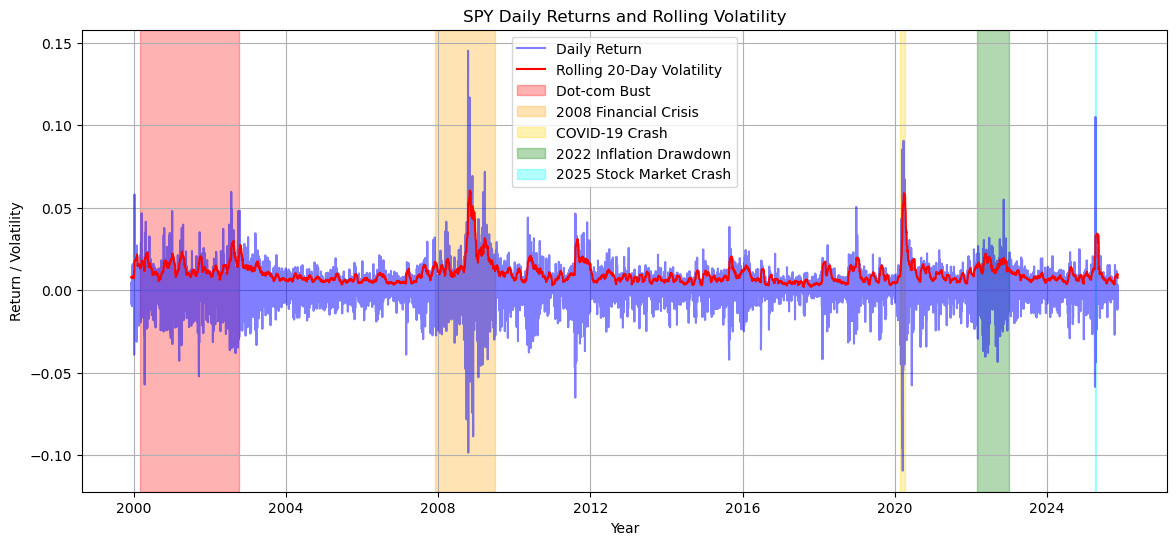

In [191]:
# Plot Returns & Volatility
plt.figure(figsize=(14,6))
plt.plot(data.index, data['Return'], color='blue', alpha=0.5, label='Daily Return')

# Rolling volatility
plt.plot(data.index, data['Volatility'], color='red', label='Rolling 20-Day Volatility')

# Crisis periods
plt.axvspan('2000-03-01', '2002-10-09', color='red', alpha=0.3, label='Dot-com Bust')
plt.axvspan('2007-12-01', '2009-06-30', color='orange', alpha=0.3, label='2008 Financial Crisis')
plt.axvspan('2020-02-20', '2020-04-07', color='gold', alpha=0.3, label='COVID-19 Crash')
plt.axvspan('2022-03-01', '2022-12-31', color='green', alpha=0.3, label='2022 Inflation Drawdown')
plt.axvspan('2025-04-02', '2025-04-10', color='cyan', alpha=0.3, label='2025 Stock Market Crash')

plt.title('SPY Daily Returns and Rolling Volatility')
plt.xlabel('Year')
plt.ylabel('Return / Volatility')
plt.legend()
plt.grid(True)
plt.show()

Major spikes/dips in daily returns correspond with high volatility. Most of these spikes/dips resulted in some kind of major financial event. 

Next, three Gaussian HMMs are fit using two-, three-, and four-components and will be graphed to see the differences between them.

In [192]:
# 2-Regime Model
hmm2 = GaussianHMM(n_components=2, covariance_type='full', n_iter=1000, random_state=4)
hmm2.fit(X)
data['Regime_2'] = hmm2.predict(X)

# 3-Regime Model
hmm3 = GaussianHMM(n_components=3, covariance_type='full', n_iter=1000, random_state=4)
hmm3.fit(X)
data['Regime_3'] = hmm3.predict(X)

# 4-Regime Model
hmm4 = GaussianHMM(n_components=4, covariance_type='full', n_iter=1000, random_state=4)
hmm4.fit(X)
data['Regime_4'] = hmm4.predict(X)

In [206]:
# Determine how many regimes the model has and labels them for easy identification
def create_regime_map(data, regime_col, sorted_states):    
    regime_map = {}
    if len(sorted_states) == 2:
        regime_map[sorted_states[0]] = 'Bull'
        regime_map[sorted_states[1]] = 'Bear'
    elif len(sorted_states) == 3:
        regime_map[sorted_states[0]] = 'Bull'
        regime_map[sorted_states[1]] = 'Sideways'
        regime_map[sorted_states[2]] = 'Bear'
    elif len(sorted_states) == 4:
        regime_map[sorted_states[0]] = 'Bull'
        regime_map[sorted_states[1]] = 'Sideways'
        regime_map[sorted_states[2]] = 'HighVol'
        regime_map[sorted_states[3]] = 'Bear'
    else:
        for i, s in enumerate(sorted_states):
            regime_map[s] = f'Regime_{i}'

    return regime_map

In [207]:
# Colored regime timeline
def plot_regime_timeline(data, regime_col):
    plt.figure(figsize=(14,6))

    regime_stats = data.groupby(regime_col)['Return'].agg(['mean', 'std'])
    sorted_states = regime_stats.sort_values(by='mean', ascending=False).index.tolist()

    regime_map = create_regime_map(data, regime_col, sorted_states)
    
    color_map = {
        'Bull': 'green',
        'Sideways': 'gold',
        'HighVol': 'gray',
        'Bear': 'red',
    }
    
    for regime, label in regime_map.items():
        subset = data[data[regime_col] == regime]
        plt.scatter(subset.index, subset['close'], color=color_map.get(label, 'blue'), s=6, label=label, alpha=0.7)
    
    plt.title(f'SPY Price with HMM {len(sorted_states)} Regimes')
    plt.xlabel('Date')
    plt.ylabel('SPY Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

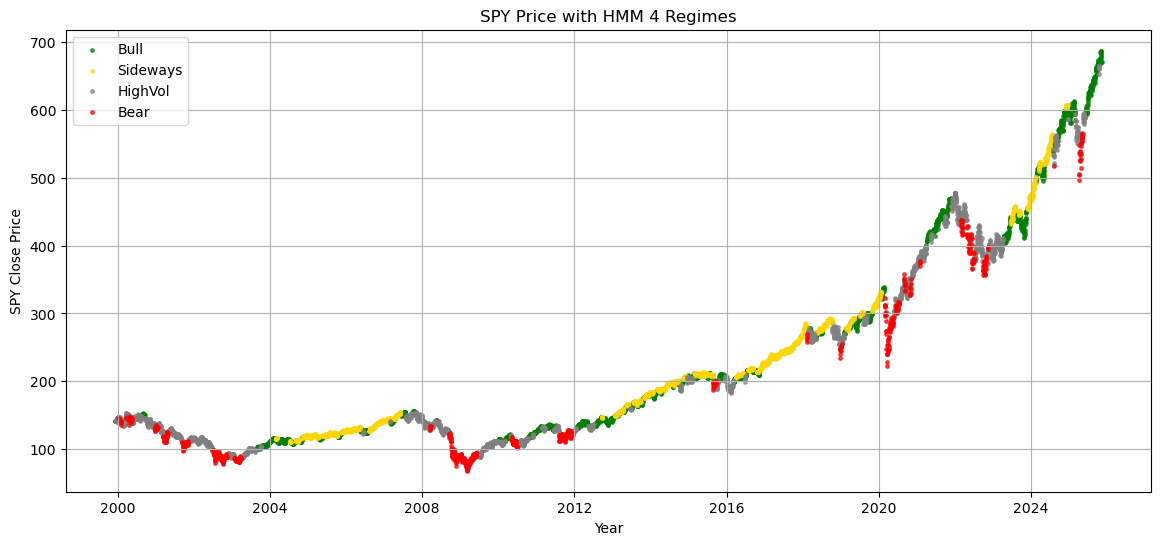

In [208]:
plot_regime_timeline(data, regime_col='Regime_4')

Although using a four-regime model appears to be the best fit according to log-likelihood/AIC/BIC, it seems overfit. Using a two- or three-regime model might be more appropriate.

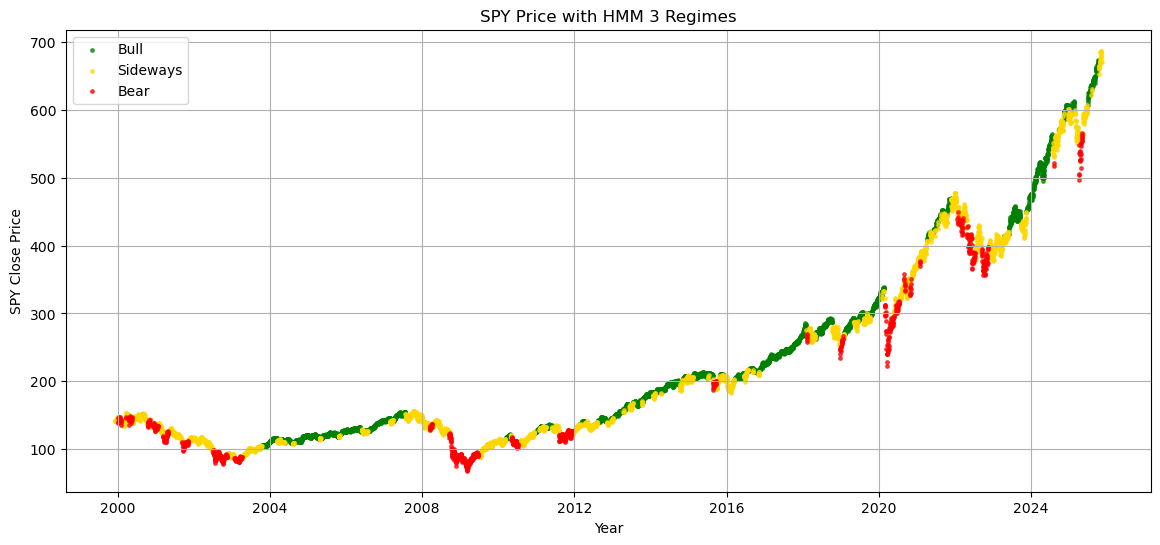

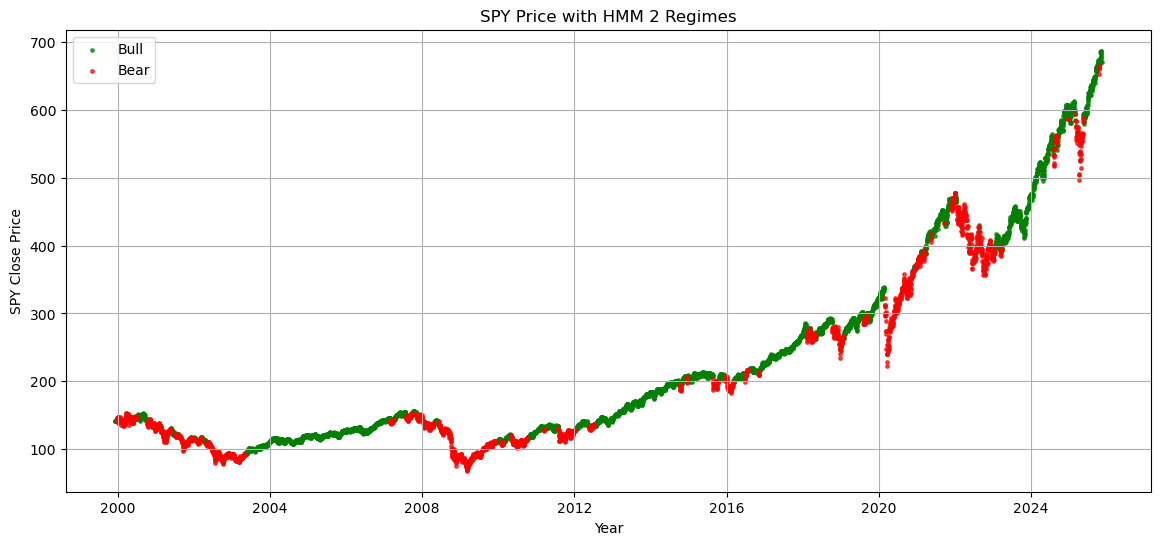

In [209]:
plot_regime_timeline(data, regime_col='Regime_3')
plot_regime_timeline(data, regime_col='Regime_2')

The three-regime model looks to be the best fit and is the next best option after the four-regime model. 

In [197]:
# Assign colors to regime labels
def assign_colors(regime_map, sorted_states):
    # Fixed label -> color map for core labels; fallback palette for extras
    fixed_colors = {'Bull': 'green', 'Bear': 'red', 'Sideways': 'gold'}
    palette = ['purple', 'blue', 'gray', 'brown', 'cyan', 'magenta']

    # Build colors dict keyed by numeric regime
    colors = {}
    for s in sorted_states:
        label = regime_map[s]
        if label in fixed_colors:
            colors[s] = fixed_colors[label]
        else:
            idx = (sorted_states.index(s) - 1) % len(palette)
            colors[s] = palette[idx]
    return colors

In [227]:
# Return timeline with shading
def plot_shaded_timeline(data, regime_col, major_events=None, use_shading=True):
    df = data.copy()

    regime_stats = data.groupby(regime_col)['Return'].agg(['mean', 'std'])
    sorted_states = regime_stats.sort_values(by='mean', ascending=False).index.tolist()

    regime_map = create_regime_map(data, regime_col, sorted_states)

    # Map numeric -> label
    df['Regime_Label'] = df[regime_col].map(regime_map)

    # Assign colors to regime map
    colors = assign_colors(regime_map, sorted_states)

    # Price Timeline
    plt.figure(figsize=(14,6))
    plt.plot(df.index, df['close'], color='black', linewidth=1, label='Price')

    if use_shading:
        regime_changes = df[regime_col].shift(1) != df[regime_col]
        change_idx = df.index[regime_changes]
        starts = list(change_idx)
        ends = list(change_idx[1:]) + [df.index[-1]]
        regimes_at_change = df.loc[change_idx, regime_col].values

        for start, end, regime in zip(starts, ends, regimes_at_change):
            plt.axvspan(start, end, color=colors.get(regime, 'gray'), alpha=0.25)
    else:
        for regime, color in colors.items():
            subset = df[df[regime_col] == regime]
            plt.scatter(subset.index, subset['close'], color=color, s=6, label=f'{regime_map.get(regime, regime)} (state {regime})', alpha=0.7)

    # Historical Event Overlay
    if major_events:
        for label, start, end, color in major_events:
            plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color=color, alpha=0.15, label=label)
            
    # Legend: Show label names (unique)
    # Build legend entires from the regime_map values in order or sorted_states
    legend_items= []
    for s in sorted_states:
        lbl = regime_map[s]
        color = colors[s]
        legend_items.append((lbl, color))
    #make unique while preserving order
    seen = set()
    legend_unique = []
    for lbl, color in legend_items:
        if lbl not in seen:
            legend_unique.append((lbl, color))
            seen.add(lbl)
    for lbl, color in legend_unique:
        plt.scatter([], [], color=color, label=lbl)

    
    plt.title(f'SPY Price with HMM {len(sorted_states)} Regimes')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

In [221]:
major_events = [
    ('Dot-com Bust', '2000-03-01', '2002-10-09', 'red'),
    ('2008 Financial Crisis', '2007-12-01', '2009-06-30', 'orange'),
    ('COVID Crash', '2020-02-20', '2020-04-07', 'gold'),
    ('2022 Inflation Drawdown', '2022-03-01', '2022-12-31', 'green'),
    ('2025 Stock Market Crash', '2025-04-02', '2025-04-10', 'cyan')
]

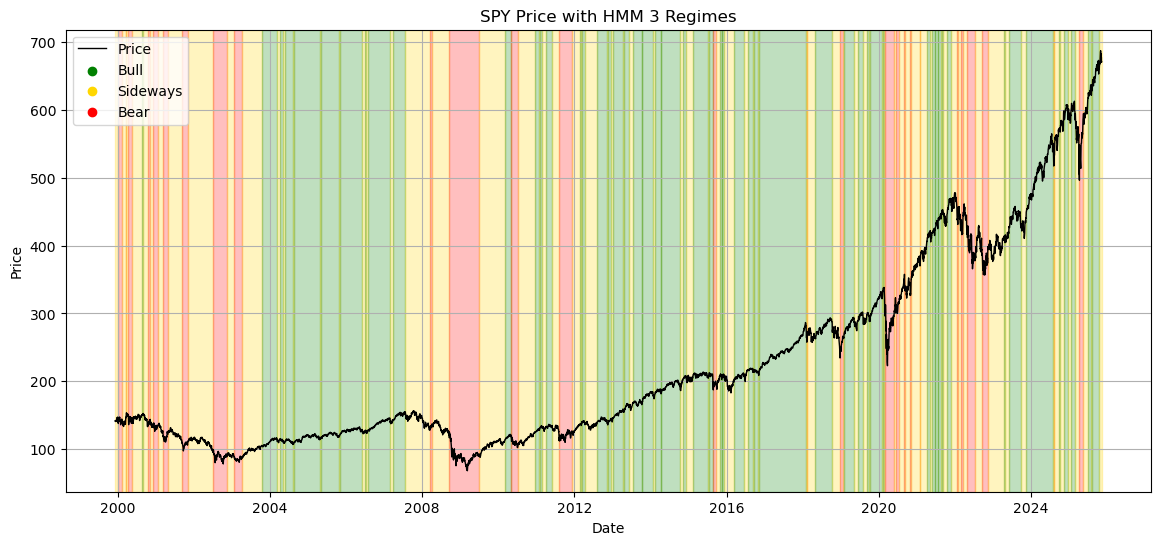

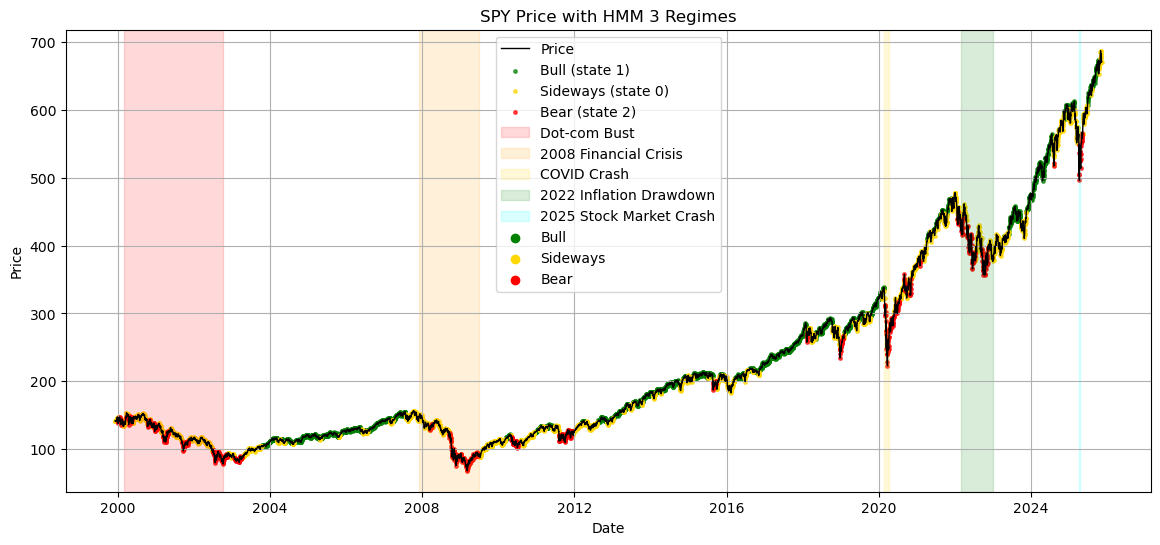

In [225]:
plot_shaded_timeline(data, regime_col='Regime_3')
plot_shaded_timeline(data, regime_col='Regime_3', major_events=major_events, use_shading=False)

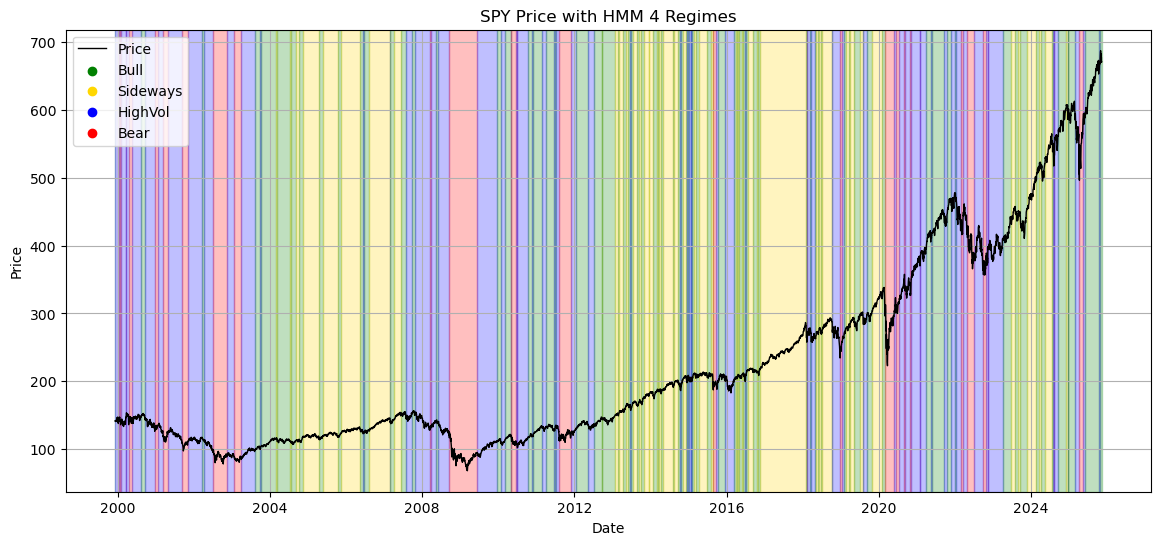

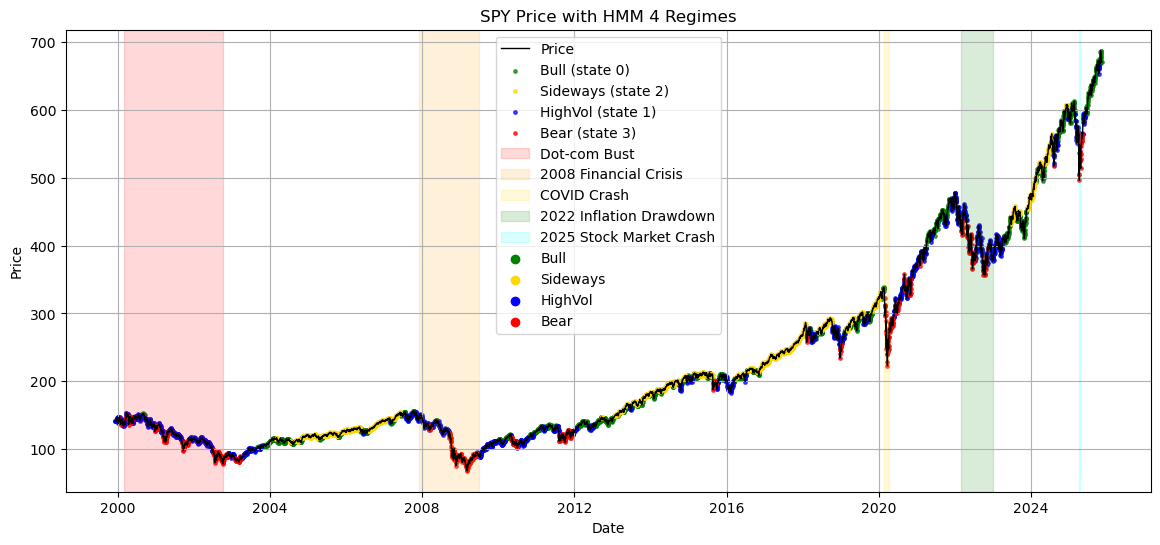

In [223]:
plot_shaded_timeline(data, regime_col='Regime_4')
plot_shaded_timeline(data, regime_col='Regime_4', major_events=major_events, use_shading=False)

Above, regimes can be seen clearly and how they line up with major financial events. 

In [200]:
# Feature space plot (return vs. volatility)
def plot_returnVvolatility(data, regime_col):
    plt.figure(figsize=(8, 6))

    df = data.copy()

    regime_stats = data.groupby(regime_col)['Return'].agg(['mean', 'std'])
    sorted_states = regime_stats.sort_values(by='mean', ascending=False).index.tolist()
    
    regime_map = create_regime_map(data, regime_col, sorted_states)
    colors = assign_colors(regime_map, sorted_states)
    
    for regime, color in colors.items():
        subset = df[df[regime_col] == regime]
        plt.scatter(subset['Volatility'], subset['Return'], s=10, color=color, alpha=0.5, label=regime_map.get(regime, f'state {regime}'))
    plt.title(f'Return vs. Volatility by Regime ({len(sorted_states)} states)')
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True)
    plt.show()

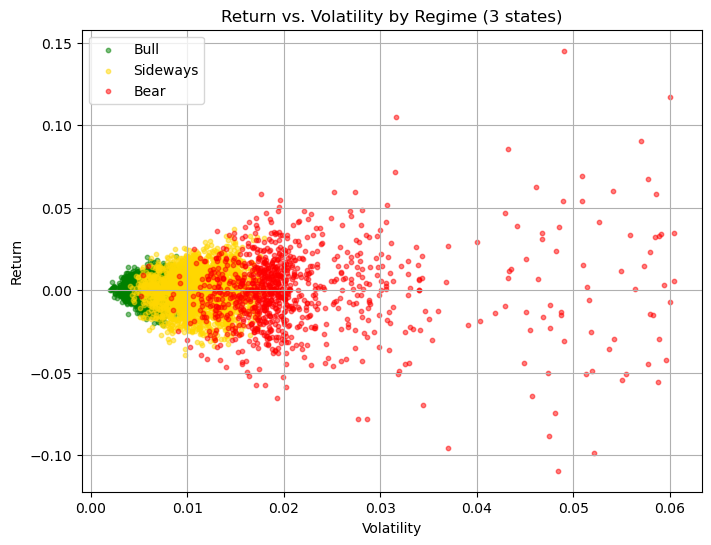

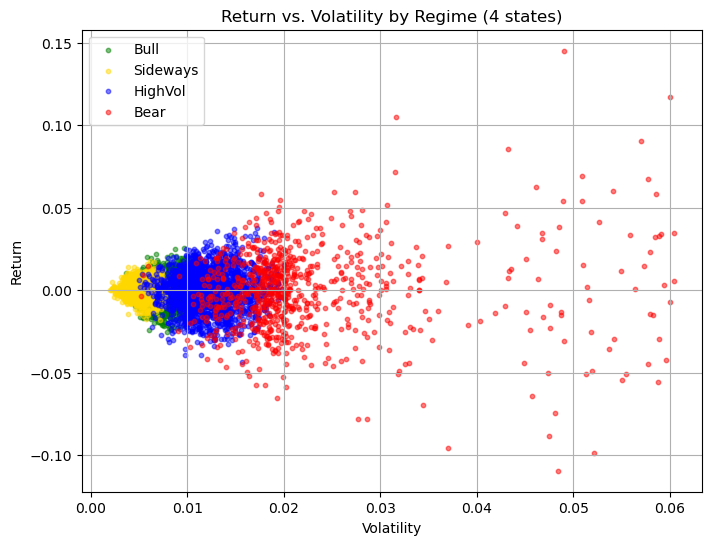

In [228]:
plot_returnVvolatility(data, 'Regime_3')
plot_returnVvolatility(data, 'Regime_4')

The highest and lowest returns appear to occur during moments of high volatility (spikes and dips).

In [230]:
def summary_stats(data, regime_col='Regime_3', return_col='Return', vol_col='Volatility'):
    df = data.copy()

    # compute stasts per numeric regime
    regime_stats = df.groupby(regime_col).agg(
        **{
            'mean_return': (return_col, 'mean'),
            'mean_vol': (vol_col, 'mean'),
            'count': (return_col, 'count')
        }
    )
    
    # Sort regimes by (mean_return desc, mean_vol asc) so higher return -> Bull
    sorted_states = sorted(
        regime_stats.index,
        key = lambda s: (regime_stats.loc[s, 'mean_return'], -regime_stats.loc[s, 'mean_vol']),
        reverse=True
    )
    #regime_stats = data.groupby(regime_col)['Return'].agg(['mean', 'std'])
    #sorted_states = regime_stats.sort_values(by='mean', ascending=False).index.tolist()
    
    regime_map = create_regime_map(data, regime_col, sorted_states)
    print('Regime Map:', regime_map)
    
    # Summary
    summary = regime_stats.copy()
    summary['Label'] = summary.index.map(regime_map)
    # order summary by sorted_states (highest mean first)
    summary = summary.reindex(sorted_states)
    summary = summary.rename(columns={'mean_return': 'Mean Return', 'mean_vol': 'Mean Volatility', 'count': 'Count'})
    print('\n=== Regime Summary Statistics ===')
    display(summary.round(6))

In [233]:
summary_stats(data, 'Regime_3')

Regime Map: {1: 'Bull', 0: 'Sideways', 2: 'Bear'}

=== Regime Summary Statistics ===


,Mean Return,Mean Volatility,Count,Label
Regime_3,,,,
1,0.000755,0.006115,2890,Bull
0,0.000071,0.010818,2669,Sideways
2,-0.000348,0.021722,962,Bear


Although the Sideways regime (regime 0) has high volatility, the mean return is still positive. This indicates it is safe to continue investing during the Sideways regime. Since the market regimes are classified as "Sideways" for about 41% of the time, it is good to know the Sideways regime does not always indicate a loss.

In [234]:
summary_stats(data, 'Regime_4')

Regime Map: {0: 'Bull', 2: 'Sideways', 1: 'HighVol', 3: 'Bear'}

=== Regime Summary Statistics ===


,Mean Return,Mean Volatility,Count,Label
Regime_4,,,,
0,0.000698,0.007718,2013,Bull
2,0.000671,0.005326,1663,Sideways
1,-0.000071,0.012096,2036,HighVol
3,-0.000420,0.022770,809,Bear


Here it is easier to see how Sideways has a positive mean return and HighVol has a negative mean return.

#### Backtest

Backtests help evaluate profitability, risk, stability, and performance, and compares the strategy to the current benchmark (SPY in this case). The regime strategy is plotted along with the historical buy and hold data to see how well the strategy would have performed and evaluate its expected real-world performance.

In [215]:
def backtest (data, regime_col='Regime', return_col='Return', initial_capital=1.0, include_sideways=True):
    df = data.copy()

    # Detect # regimes
    n_regimes = len(sorted(df[regime_col].unique()))
    print(f'Detected {n_regimes} regimes.')
    

    # Apply correct regime mapping/labels
    regime_stats = data.groupby(regime_col)[return_col].agg(['mean', 'std'])
    sorted_states = regime_stats.sort_values(by='mean', ascending=False).index.tolist()
    regime_map = create_regime_map(data, regime_col, sorted_states)
    df['Regime_Label'] = df[regime_col].map(regime_map)
    

    # Define pos based on regimes
    if include_sideways:
        df['position'] = np.where(df['Regime_Label'].isin(['Bull', 'Sideways']), 1, 0)
    else:
        df['position'] = np.where(df['Regime_Label'] == 'Bull', 1, 0)

    # Strategy daily returns
    df['position'] = df['position'].shift(1).fillna(0) #fillna(0)?
    df['strategy_return'] = df['position'] * df[return_col]

    # Cumulative performance
    df['cum_strategy'] = (1 + df['strategy_return']).cumprod() * initial_capital
    df['cum_buyhold'] = (1 + df[return_col]).cumprod() * initial_capital

    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(df.index, df['cum_buyhold'], label='Buy & Hold', color='gray', linewidth=2)
    plt.plot(df.index, df['cum_strategy'], label='Regime Strategy', color='blue', linewidth=2)
    plt.title(f'Regime-Based Strategy vs. Buy & Hold ({n_regimes} Regimes)')
    plt.xlabel('Year')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Summary Stats
    final_strategy = df['cum_strategy'].iloc[-1]
    final_buyhold = df['cum_buyhold'].iloc[-1]
    outperformance = (final_strategy / final_buyhold - 1) * 100

    print('=== Strategy Summary ===')
    print(f'Final Portfolio Value (Strategy): {final_strategy:.3f}')
    print(f'Final Portfolio Value (Buy & Hold): {final_buyhold:.3f}')
    print(f'Outperformance: {outperformance:.2f}%')

    return df[['cum_strategy', 'cum_buyhold', 'strategy_return', 'position']]

Detected 3 regimes.


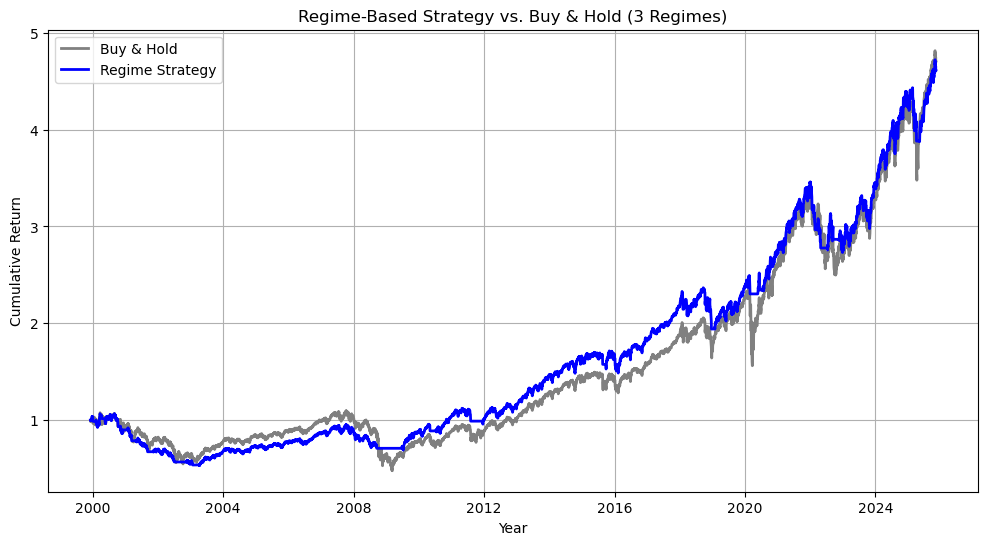

=== Strategy Summary ===
Final Portfolio Value (Strategy): 4.608
Final Portfolio Value (Buy & Hold): 4.699
Outperformance: -1.94%
Detected 2 regimes.


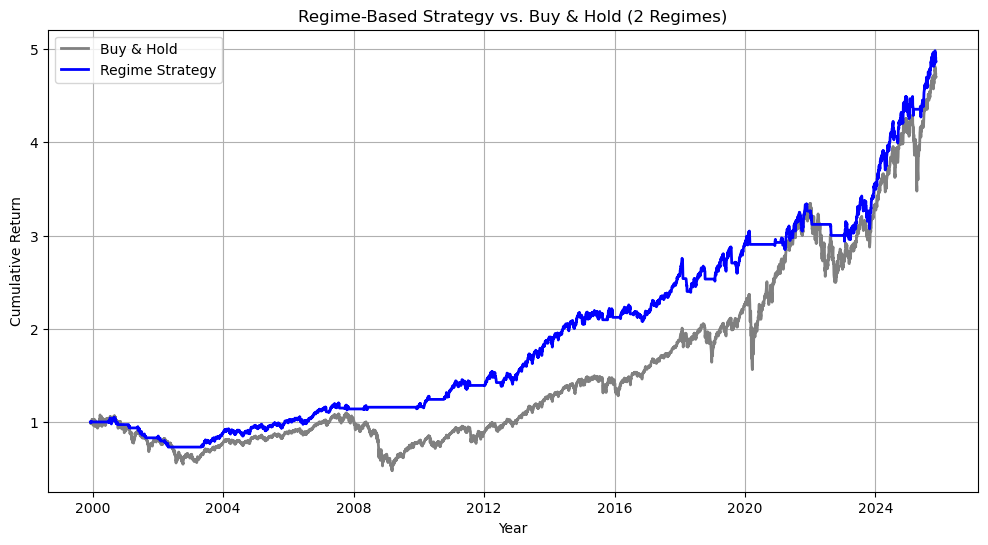

=== Strategy Summary ===
Final Portfolio Value (Strategy): 4.864
Final Portfolio Value (Buy & Hold): 4.699
Outperformance: 3.52%
Detected 4 regimes.


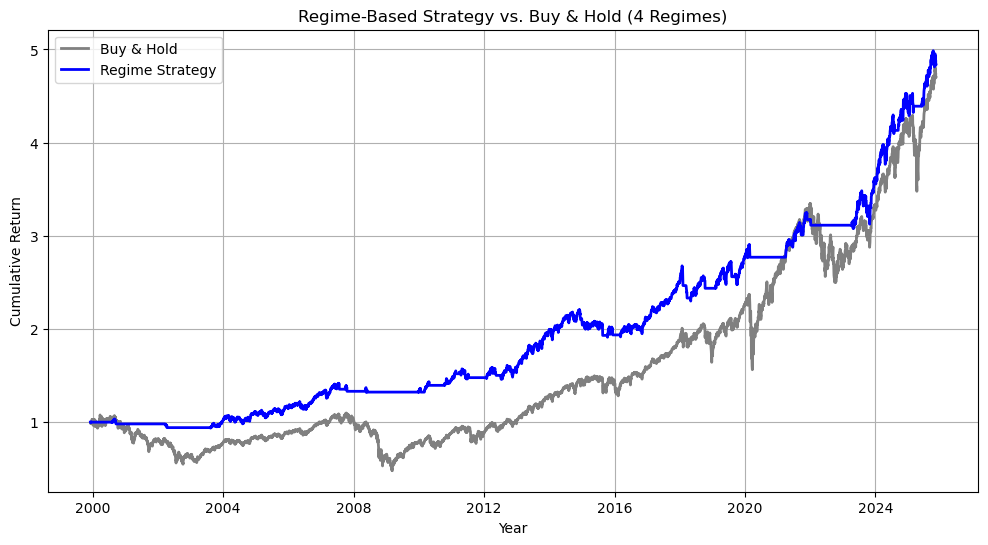

=== Strategy Summary ===
Final Portfolio Value (Strategy): 4.835
Final Portfolio Value (Buy & Hold): 4.699
Outperformance: 2.89%


,cum_strategy,cum_buyhold,strategy_return,position
timestamp,,,,
1999-12-07 14:30:00,1.000000,0.991902,-0.000000,0.0
1999-12-08 14:30:00,0.993601,0.985555,-0.006399,1.0
1999-12-09 14:30:00,0.998455,0.990370,0.004886,1.0
1999-12-10 14:30:00,0.998455,0.993653,0.000000,0.0
1999-12-13 14:30:00,0.998455,0.995404,0.000000,0.0
...,...,...,...,...
2025-11-03 14:30:00,4.924308,4.785923,0.001877,1.0
2025-11-04 14:30:00,4.865938,4.729192,-0.011854,1.0
2025-11-05 14:30:00,4.882800,4.745581,0.003465,1.0


In [216]:
backtest(data, regime_col='Regime_2')
backtest(data, regime_col='Regime_3')
backtest(data, regime_col='Regime_4')

A positive outperformance indicates that this HMM strategy overperformed SPY, while a negative outperformance indicates that the strategy underperformed SPY. Using two and four regimes, the model overperformed SPY by 3.52% and 2.89% respectively, while using three regimes resulted in an underperformance of -1.94%. Since the fit evaluation suggested that the four-regime model is the best fit and the backtest supports this, the four-regime model is the best-fit model. Since the fit evaluation suggested that the two-regime model is the worst fit and the backtest suggests it is the best fit, the two-regime model is most likely underfit. 

### Conclusion

After evaluating and visualizing the models with two, three, and four regimes, the four-regime model is the best-fit model for detecting SPY regimes. The four-regime model has the lowest AIC and BIC, and the log-likelihood closest to 0, indicating it is the best-fit model out of the three. After visualizing the shaded price timelines with major event overlays, return vs. volatility, and regime strategy vs. buy and hold, it is clear that the four-regime model is the best model. It overperforms SPY by 2.89% and allows for easier market prediction. 